

#### Data Cleaning Process:
- merged datasets together 
- selected site id 38 and meter 10
- dropped irrelevant columns 
- selected day, weekday, month, hour, year from timestamp
- ensured that all energy measurements are in the same units
- transformed our target variable by differencing values in energy measurements
- feature engineering:
    - twice differenced the energy measurements
    - accounted for weekly and monthly lags 
- selecting years 2012-2015 for training set and 2016,2017 for test set
    - Train dataset contains 34,172 observations. Test contains 16,708
- looked into and removed potential outliers for quantitative variables

Datasets merged together:

- training-data included information on energy recorded by meters and timestamp for record
- weather data included local temperatures for meter sites
- metadata included information about meters 
- holiday included whether the timestamp was a holiday 
- distance contains information on how far the weather station is from the meter. We are only looking into one meter so we it is the same value for every observation. 
- units - we accounted for the differing units so this column is irrelevant now. 

Columns dropped during data cleaning process:
- site_idm and meter id as all for meter 10 at site 38 
- surface as it all NaN values
- dates as we have the timestamp column
- we created a dummy for holiday so we can lose the other holiday columns 

### Independent variables:
'Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift'

### Dependent variable: 
'tv delta'


In [1]:
import pandas as pd
import numpy as np

#importing datasets
tr = pd.read_csv('training-data.csv',sep=";")
w = pd.read_csv('weather.csv',sep=";")
m = pd.read_csv('metadata.csv',sep=";")
h = pd.read_csv('power-laws-detecting-anomalies-in-usage-holidays.csv', sep=";")

In [2]:
#ensuring site id are same data type in weather/metadata/holiday to merge
w['site_id'] = w['site_id'].astype(float)

m.loc[m['site_id'] == '038', 'site_id'] = 38
m['site_id'] = m['site_id'].astype(float)

h.loc[h['site_id'] == '038', 'site_id'] = 38
h['site_id'] = h['site_id'].astype(float)

In [3]:
#merging weather with meta data
merge = m.merge(w, on= 'site_id', how='inner', suffixes = ['m', 'w'])

In [4]:
#meter ids must be same datatype to merge
merge['meter_id'] = merge['meter_id'].astype(float)
tr['meter_id'] = tr['meter_id'].astype(float)

In [5]:
#selected site id 38 and meter 10
h = h[h['site_id'] == 38]
merge = merge[merge['meter_id'] == 3810110.0]
tr = tr[tr['meter_id'] == 3810110.0]

In [6]:
#merging meter data with meta/weather data
merge2 = pd.merge(tr,merge,how='inner',on=['meter_id','Timestamp'])

### Dealing with time: making date a timestamp to merge holidays with the rest of the data

In [7]:
from datetime import datetime

#standardizes all times to same timezone: UTC 9coordinated universal time) 
merge2['Timestamp'] = pd.to_datetime(merge2['Timestamp'], utc=True)
h['Timestamp'] = pd.to_datetime(h['Date'], utc=True)

#grabbing just dates
merge2['dates'] = merge2['Timestamp'].dt.date
h['dates'] = h['Timestamp'].dt.date

In [8]:
#left join to merge holiday data
merge3 = pd.merge(merge2,h,how='left',on=['dates'],suffixes = ['m','h']) 

In [9]:
#creating holiday dummy, a 0 if not a holiday and a 1 if it is a holiday 
merge3['holiday'] = np.where(merge3['Holiday'].isna(), 0, 1)

In [10]:
#there are 1,472 holidays in this data set 
merge3['holiday'].value_counts()

0    49414
1     1472
Name: holiday, dtype: int64

In [11]:
#dropping irrelevant columns
merge3 = merge3.drop(['meter_id','site_idm','surface','dates','Date','Holiday','site_idh','Timestamph'],axis=1)

In [12]:
#renaming timestamp to a more simple name
merge3.rename(columns = {'Timestampm':'Timestamp'}, inplace = True) 

#### Dealing with missing values:

Some rows are missing all values, we will remove these rows. 

In [13]:
merge3.dropna(axis = 0, how='any', inplace = True)

### Dealing with time: selecting day, weekday, month, hour, year from timestamp

In [14]:
#breaking timestamp down 
def timestamp(df):
    df['Weekday'] = df['Timestamp'].dt.weekday
    df['Hour'] = df['Timestamp'].dt.hour
    df['Month'] = df['Timestamp'].dt.month
    df['Day'] = df['Timestamp'].dt.day
    
    # ensuring no duplicates
    df = df.groupby(['Timestamp']).first()
    df.reset_index(level=0, inplace=True)
    return df

#renaming dataset to a more simple name
df = timestamp(merge3)

### Standardizing units of measurement to kwh

We are interested in predicting the energy measurements in the values column. The units column contains 3 different units:  kwh, count, and degree celsius. The following code converts them all to kwh

In [15]:
#ignore count column - just convert everything to KWH
import numpy as np

def to_kwh(row):
    if 'degree celsius' in row['units']:
        kwh = 0.00052753*row['Values']
    elif 'kWh' in row['units']:
        kwh = row['Values']
    elif 'count' in row['units']:
        kwh = np.nan
    return kwh

#applying above function to every row
df['kwh values'] = df.apply(lambda row: to_kwh(row), axis=1)

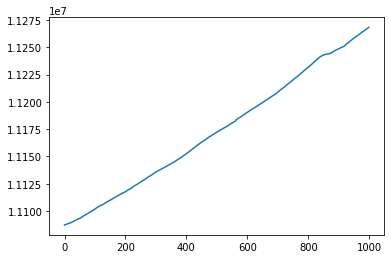

In [16]:
import matplotlib.pyplot as plt
plt.plot(df['kwh values'].iloc[:1000])

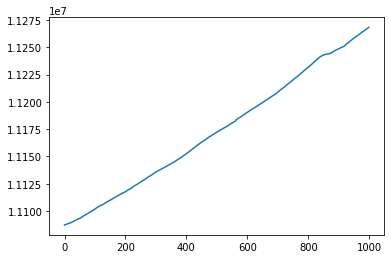

In [17]:
plt.plot(df['Values'].iloc[:1000])

Note that there is no difference between the plots. This indicates that the values column was likely already converted to kwh. It's great we double checked! 

We will use the original values column as it contains additional values for when the units is count. We had ignored these as did not know how to interpret this measurement

__ALSO__ notice how the line is not perfectly straight but has a few bumps. This indicates anomolies in energy usage. 

In [18]:
df = df.drop(['kwh values'], axis=1)

### Feature engineering: Differencing

Observe from the above plots that the energy measurements are cumulative. As we are interested in detecting anomolies, we need to difference consecutive measurement values. Anomolies occur when the differences between measurements are very odd.


1. We found the differences by shifting the timestamp values (time delta). 
2. We then found the difference in measurements (value delta)
3. To account for the dataset not always having consecutive time measurements, we divided the measurement difference by the hours in between measurements. This will normalize our difference and will aid in detecting anomolies. The below dataframe shows 484 observatings where time was not measured consecutively. If we merely used the value delta without accounting for the time difference, our model would assume it is an anomoly since it's a very high value. 
4. tv delta is the name of our normalized difference variable. This will be our new target feature


In [19]:
df['Time Delta'] = df['Timestamp'] - df['Timestamp'].shift(periods=1, axis=0)
df['value delta'] = df['Values'] - df['Values'].shift(periods=1, axis=0)

oneday = pd.Timedelta(days=1)

 #converting time delta to just an hours measurement 
df['Time Delta'] = df['Time Delta']/np.timedelta64(1,'h')
#normalizing differences
df['tv delta'] = df['value delta']/df['Time Delta']

In [20]:
df[df['Time Delta'] != 1.0]

,Timestamp,Values,meter_description,units,activity,Temperature,Distance,holiday,Weekday,Hour,Month,Day,Time Delta,value delta,tv delta
0,2012-01-01 01:00:00+00:00,11087284.0,other,kWh,laboratory,3.9,11.902932,1,6,1,1,1,NaN,NaN,NaN
563,2012-01-24 16:00:00+00:00,11183610.0,other,kWh,laboratory,9.9,11.902932,0,1,16,1,24,5.0,934.0,186.800000
1842,2012-03-18 01:00:00+00:00,11391625.0,other,kWh,laboratory,5.3,11.902932,0,6,1,3,18,3.0,354.0,118.000000
2011,2012-03-25 03:00:00+00:00,11413237.0,other,kWh,laboratory,6.8,11.902932,0,6,3,3,25,2.0,232.0,116.000000
2427,2012-04-11 12:00:00+00:00,11464523.0,other,kWh,laboratory,12.1,11.902932,0,2,12,4,11,2.0,237.0,118.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47876,2017-09-18 20:00:00+00:00,17625786.0,other,kWh,laboratory,14.2,11.902932,0,0,20,9,18,2.0,175.0,87.500000
47908,2017-09-20 05:00:00+00:00,17628544.0,other,kWh,laboratory,6.1,11.902932,0,2,5,9,20,2.0,160.0,80.000000
48131,2017-09-29 13:00:00+00:00,17651338.0,other,kWh,laboratory,21.7,11.902932,0,4,13,9,29,2.0,334.0,167.000000
48883,2017-10-31 07:00:00+00:00,17721054.0,other,kWh,laboratory,7.5,11.902932,0,1,7,10,31,11.0,700.0,63.636364


Dropping first row since it contains an NaN value for tv delta bc of differencing

In [21]:
df = df.iloc[1:]

Observe a clear anomaly using these new differenced values

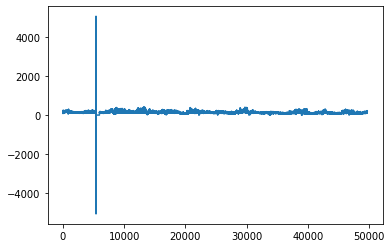

In [22]:
df['tv delta'].plot()

### Feature engineering: Lagged Values

- We difference the data twice to grab the two previous differenced values. 
- We then account for month and weekday seasonality by grabbing the differenced values that occurred in the previous day and the previous month. There might be a slight error here as just under 500 observations were not recorded every hour. However, we expect these values to still be a useful approximation of the month/weekday shift

In [23]:
df['prev value'] = df['tv delta'].shift(periods=1, axis=0)

In [24]:
df['twice prev value'] = df['tv delta'].shift(periods=2, axis=0)

In [25]:
#accounting for month and weekday seasonality

df['day shift'] = df['tv delta'].shift(periods=24, axis=0)
df['month shift'] = df['tv delta'].shift(periods=24*30, axis=0)

In [26]:
#Dropping rows that contain an NaN value for tv delta bc of differencing
df.dropna(axis = 0, how='any', inplace = True)

In [27]:
df.head()

,Timestamp,Values,meter_description,units,activity,Temperature,Distance,holiday,Weekday,Hour,Month,Day,Time Delta,value delta,tv delta,prev value,twice prev value,day shift,month shift
721,2012-01-31 06:00:00+00:00,11213381.0,other,kWh,laboratory,0.3,11.902932,0,1,6,1,31,1.0,224.0,224.0,203.0,215.0,205.0,97.0
722,2012-01-31 07:00:00+00:00,11213635.0,other,kWh,laboratory,0.2,11.902932,0,1,7,1,31,1.0,254.0,254.0,224.0,203.0,242.0,107.0
723,2012-01-31 08:00:00+00:00,11213893.0,other,kWh,laboratory,0.2,11.902932,0,1,8,1,31,1.0,258.0,258.0,254.0,224.0,248.0,106.0
724,2012-01-31 09:00:00+00:00,11214154.0,other,kWh,laboratory,0.2,11.902932,0,1,9,1,31,1.0,261.0,261.0,258.0,254.0,242.0,95.0
725,2012-01-31 10:00:00+00:00,11214422.0,other,kWh,laboratory,0.4,11.902932,0,1,10,1,31,1.0,268.0,268.0,261.0,258.0,234.0,103.0


Activity and meter description only have one value, we will drop these. 

In [28]:
df['activity'].value_counts()

laboratory    49003
Name: activity, dtype: int64

In [29]:
df['meter_description'].value_counts()

other    49003
Name: meter_description, dtype: int64

Dropping Irrelevant Columns:

- Distance contains information on how far the weather station is from the meter. We are only looking into one meter so we it is the same value for every observation. 

- We accounted for the differing units so this column is irrelevant now. 

In [30]:
df.drop(['Distance','units','activity','meter_description'], axis = 1, inplace=True)

In [31]:
df.head()

,Timestamp,Values,Temperature,holiday,Weekday,Hour,Month,Day,Time Delta,value delta,tv delta,prev value,twice prev value,day shift,month shift
721,2012-01-31 06:00:00+00:00,11213381.0,0.3,0,1,6,1,31,1.0,224.0,224.0,203.0,215.0,205.0,97.0
722,2012-01-31 07:00:00+00:00,11213635.0,0.2,0,1,7,1,31,1.0,254.0,254.0,224.0,203.0,242.0,107.0
723,2012-01-31 08:00:00+00:00,11213893.0,0.2,0,1,8,1,31,1.0,258.0,258.0,254.0,224.0,248.0,106.0
724,2012-01-31 09:00:00+00:00,11214154.0,0.2,0,1,9,1,31,1.0,261.0,261.0,258.0,254.0,242.0,95.0
725,2012-01-31 10:00:00+00:00,11214422.0,0.4,0,1,10,1,31,1.0,268.0,268.0,261.0,258.0,234.0,103.0


### Splitting into test and train by year. Our train set will contain years 2012-2015 and our test set will contain years 2016-2017

Train dataset contains 33,893 observations. Test contains 15,828

In [32]:
#grabbing year
def year(df):
    df['year'] = df['Timestamp'].dt.year
    return df

df = year(df)

In [33]:
#only selecting years 2012-2015 for training set
years = [2012,2013,2014,2015]
train = df[df.year.isin(years)]

#selecting 2016,2017 for test set
years1 = [2016,2017]
test= df[df.year.isin(years1)]

In [34]:
len(train)

33175

In [35]:
len(test)

15828

### Looking into outliers

In [36]:
# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(data):
    
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 3
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

Temperature contains 2 outliers values however this is small in comparison so the number of observations in our dataset and will not yield much influence over our model. We will ignore this for now. 

There are no outliers in the Value column but are many in the differenced value (this further confirms our method to take differenced amounts). Many of these values are around 300, indicating they are anomolies. There are two outliers around +/- 5000. Let's look into these



In [37]:
print('Measurement value outliers:', find_anomalies(train['Values']))
print('Differenced value outliers:', find_anomalies(train['tv delta']))
print('Temp outliers:', find_anomalies(train['Temperature']))

Measurement value outliers: []
Differenced value outliers: [5095.0, -5095.0, 333.0, 358.0, 369.0, 346.0, 345.0, 329.0, 392.0, 346.0, 373.0, 366.0, 356.0, 331.0, 364.0, 331.0, 340.0, 359.0, 371.0, 383.0, 356.0, 328.0, 328.0, 336.0, 333.0, 342.0, 345.0, 332.0, 341.0, 336.0, 338.0, 348.0, 357.0, 356.0, 371.0, 359.0, 351.0, 336.0, 347.0, 353.0, 364.0, 368.0, 360.0, 337.0, 334.0, 336.0, 339.0, 340.0, 348.0, 345.0, 344.0, 345.0, 344.0, 347.0, 335.0, 330.0, 344.0, 358.0, 359.0, 349.0, 336.0, 344.0, 330.0, 354.0, 371.0, 371.0, 348.0, 358.0, 369.0, 388.0, 425.0, 419.0, 364.0, 331.0, 355.0, 363.0, 371.0, 378.0, 390.0, 373.0, 355.0, 345.0, 377.0, 412.0, 392.0, 392.0, 386.0, 360.0, 333.0, 331.0, 350.0, 354.0, 362.0, 373.0, 366.0, 341.0, 331.0, 342.0, 336.0, 334.0, 359.0, 366.0, 331.0, 341.0, 340.0, 338.0, 334.0, 333.0, 349.0, 335.0, 350.0, 357.0, 387.0, 371.0, 356.0, 333.5, 334.0, 338.0, 338.0, 334.0, 333.0, 349.0, 354.0, 341.0, 362.0, 361.0, 364.0, 328.0, 335.0, 334.0, 329.0, 351.0, 335.0, 340.0,

Looking into these values

In [38]:
df[abs(df['tv delta']) == 5095.0]

,Timestamp,Values,Temperature,holiday,Weekday,Hour,Month,Day,Time Delta,value delta,tv delta,prev value,twice prev value,day shift,month shift,year
5407,2012-08-20 09:00:00+00:00,11916652.0,22.1,0,0,9,8,20,1.0,5095.0,5095.0,0.0,0.0,132.0,113.0,2012
5408,2012-08-20 10:00:00+00:00,11911557.0,24.8,0,0,10,8,20,1.0,-5095.0,-5095.0,5095.0,0.0,132.0,124.0,2012


We think it's safe to assume this is a data input error. We will remove these 2 rows from our dataset. 

In [40]:
train_no_outliers = train[train['Timestamp'] != '2012-08-20 09:00:00+00:00']
train_no_outliers = train_no_outliers[train_no_outliers['Timestamp'] != '2012-08-20 10:00:00+00:00']

In [41]:
train = train_no_outliers

#### Finalizing datasets

In [42]:
train.head()

,Timestamp,Values,Temperature,holiday,Weekday,Hour,Month,Day,Time Delta,value delta,tv delta,prev value,twice prev value,day shift,month shift,year
721,2012-01-31 06:00:00+00:00,11213381.0,0.3,0,1,6,1,31,1.0,224.0,224.0,203.0,215.0,205.0,97.0,2012
722,2012-01-31 07:00:00+00:00,11213635.0,0.2,0,1,7,1,31,1.0,254.0,254.0,224.0,203.0,242.0,107.0,2012
723,2012-01-31 08:00:00+00:00,11213893.0,0.2,0,1,8,1,31,1.0,258.0,258.0,254.0,224.0,248.0,106.0,2012
724,2012-01-31 09:00:00+00:00,11214154.0,0.2,0,1,9,1,31,1.0,261.0,261.0,258.0,254.0,242.0,95.0,2012
725,2012-01-31 10:00:00+00:00,11214422.0,0.4,0,1,10,1,31,1.0,268.0,268.0,261.0,258.0,234.0,103.0,2012


In [43]:
test.head()

,Timestamp,Values,Temperature,holiday,Weekday,Hour,Month,Day,Time Delta,value delta,tv delta,prev value,twice prev value,day shift,month shift,year
33896,2016-01-01 00:00:00+00:00,15838241.0,5.0,1,4,0,1,1,1.0,41.0,41.0,29.0,41.0,19.0,123.0,2016
33897,2016-01-01 01:00:00+00:00,15838284.0,5.0,1,4,1,1,1,1.0,43.0,43.0,41.0,29.0,19.0,125.0,2016
33898,2016-01-01 02:00:00+00:00,15838314.0,5.0,1,4,2,1,1,1.0,30.0,30.0,43.0,41.0,19.0,121.0,2016
33899,2016-01-01 03:00:00+00:00,15838356.0,5.2,1,4,3,1,1,1.0,42.0,42.0,30.0,43.0,18.0,117.0,2016
33900,2016-01-01 04:00:00+00:00,15838399.0,5.2,1,4,4,1,1,1.0,43.0,43.0,42.0,30.0,20.0,130.0,2016


In [44]:
test.to_csv('test.csv')
train.to_csv('train.csv')

### names of independent variables:
'Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift'

### name of dependent variable: 
'tv delta'
